# **Random Forest**

I've decided to use as a model the Random Forest because:
- it exploit bagging to improve accuracy of the Decision Trees
- each node is built on a small subset of the feature set to force the algortihm to use different features for each model (improving independency between them)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

#### DATA PREPARATION

train_features = df_train.columns.tolist()
test_features = df_test.columns.tolist()
features_toremove =  list(set(train_features) - set(test_features) - {'sii'})

del df_train['id']
for col in features_toremove:
    del df_train[col]
df_train.dropna(subset=['sii'], inplace=True)

physical_measures_df = pd.read_csv('data/physical_measures.csv')
df_train = df_train.merge( physical_measures_df, on=['Basic_Demos-Age', 'Basic_Demos-Sex'], suffixes=('', '_avg')) # add the column of the average physical measures to each row in the dataframe

cols = ['Physical-BMI','Physical-Height','Physical-Weight','Physical-Waist_Circumference','Physical-Diastolic_BP','Physical-HeartRate','Physical-Systolic_BP']
for col in cols:
    df_train[col] = df_train[col].fillna(df_train[f"{col}_avg"])
    del df_train[f"{col}_avg"]


X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]

is_numerical = np.array([np.issubdtype(dtype, np.number) for dtype in X.dtypes])
numerical_idx = np.flatnonzero(is_numerical)
new_X = X.iloc[:, numerical_idx]

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_array = imputer.fit_transform(new_X)
new_X = pd.DataFrame(X_array, columns=new_X.columns, index=new_X.index)

categorical_idx = np.flatnonzero(is_numerical==False)
categorical_X = X.iloc[:, categorical_idx]
imputer = SimpleImputer(strategy='most_frequent')
X_array = imputer.fit_transform(categorical_X)
categorical_X = pd.DataFrame(X_array, columns=categorical_X.columns, index=categorical_X.index)


from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(sparse_output=False)
oh.fit(categorical_X)

encoded = oh.transform(categorical_X)
for i, col in enumerate(oh.get_feature_names_out()):
    new_X = new_X.copy()
    new_X[col] = encoded[:, i]

Let's start with a Random Forest classifier with automatic-tuned hyperparameters, and see how does it perform:

In [4]:
X_train, X_test, y_train, y_test = train_test_split( new_X, y, test_size=0.20)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

base_model = RandomForestClassifier()
parameters = { 'n_estimators': [100],
    'max_leaf_nodes': [30, 50, 80, 100],
    'criterion': ['gini', 'entropy']
    }
tuned_model = GridSearchCV(base_model, parameters, cv=5, n_jobs=-1)
tuned_model.fit(X_train, y_train)
print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print("Best Params: ", tuned_model.best_params_)
test_acc = accuracy_score(y_true = y_test, y_pred = tuned_model.predict(X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

Best Score: 0.608
Best Params:  {'criterion': 'entropy', 'max_leaf_nodes': 100, 'n_estimators': 100}
Test Accuracy: 0.630


As we can see we get a model that is similiar to the one we get before, but slighty better.
Let's investigate better the performance using a Confusion Matrix

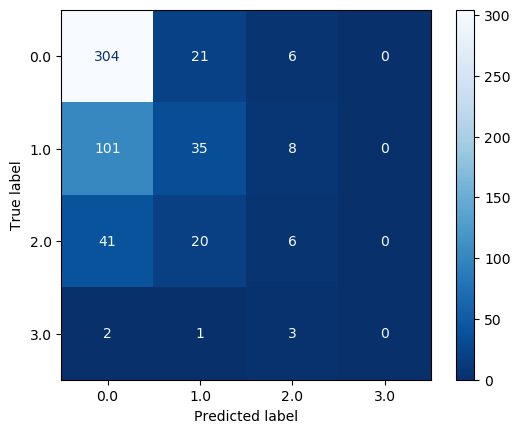

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    estimator=tuned_model.best_estimator_,
    X=X_test, y=y_test,
    cmap = 'Blues_r')

We can see that class 0 has the most of the instances, so it has a larger impact on the final measure. <br>
Let's try to give a weight inversely proportional to the frequency to balance this imbalanced data.

In [6]:
base_model = RandomForestClassifier(class_weight='balanced') # give weight to the class that are inversely proportional to frequency
parameters = { 'n_estimators': [100],
    'max_leaf_nodes': [30, 50, 80, 100],
    'criterion': ['gini', 'entropy']
    }
tuned_model = GridSearchCV(base_model, parameters, cv=5, n_jobs=-1)
tuned_model.fit(X_train, y_train)
print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print("Best Params: ", tuned_model.best_params_)
test_acc = accuracy_score(y_true = y_test, y_pred = tuned_model.predict(X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

Best Score: 0.559
Best Params:  {'criterion': 'gini', 'max_leaf_nodes': 100, 'n_estimators': 100}
Test Accuracy: 0.566


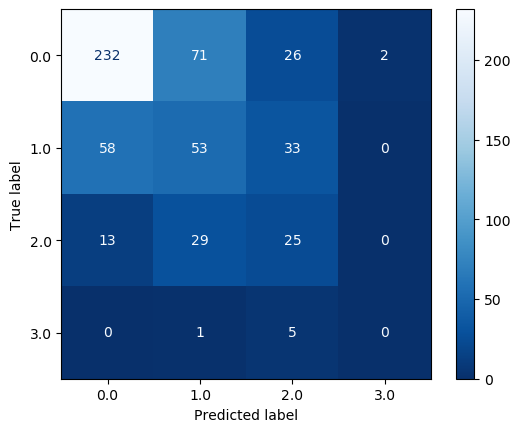

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    estimator=tuned_model.best_estimator_,
    X=X_test, y=y_test,
    cmap = 'Blues_r')

As we can see this time we got a lower accuracy, but at least the prediction of the model are balanced -> the classifier is able to also predict instances that are not from class 0.

Let's now try to investigate the importance of the features:

Feature Importances:
[0.04502463 0.00419876 0.0218039  0.02963109 0.05702436 0.03701537
 0.04393177 0.02153934 0.02370135 0.02812185 0.00215052 0.00262774
 0.00357756 0.01919549 0.00304607 0.01263844 0.00587188 0.01909595
 0.00448444 0.01473849 0.00367995 0.01243856 0.0038781  0.01577773
 0.00241422 0.01632264 0.00392363 0.00637163 0.01454367 0.01909979
 0.01699599 0.02575872 0.02058497 0.0238439  0.01596499 0.01579764
 0.02186397 0.00367581 0.02642264 0.03075452 0.01941674 0.03333288
 0.02044686 0.00672973 0.02680404 0.03116903 0.04142238 0.0278527
 0.00275442 0.00272535 0.00264537 0.00282899 0.00240489 0.00278656
 0.00188202 0.00254164 0.002395   0.00186893 0.00280138 0.0038648
 0.00092008 0.00148082 0.00094083 0.00363394 0.00293264 0.00217194
 0.00285282 0.00281144 0.00110743 0.00200543 0.0033651  0.00090589
 0.00072005 0.00087264 0.00106406 0.00332447 0.0009377  0.00287641
 0.00280014 0.00214986 0.00127676 0.00282333 0.00236304 0.00399545
 0.00187696 0.00318279 0.00337462 0.0030275

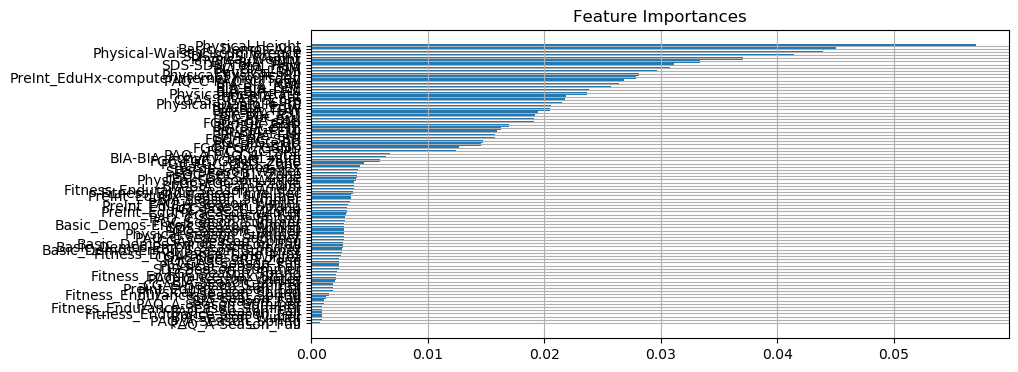

In [8]:
print("Feature Importances:")
print(tuned_model.best_estimator_.feature_importances_)
feature_names = X_train.columns.tolist()

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(X_train.shape[1]), sorted(tuned_model.best_estimator_.feature_importances_)[::-1])
ax.set_title("Feature Importances")
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(np.array(feature_names)[np.argsort(tuned_model.best_estimator_.feature_importances_)[::-1]])
ax.invert_yaxis() 
ax.grid()

Since we have a lot of features and some of them are not very informative let's try to select a subset of the most informative features. <br>
In this way we reduce the risks of random collection and reduce the generalization error of the model. <br>
To do this I perform a Recursive Elimination in a cross-validation loop to find the best number of features:

In [10]:
from sklearn.feature_selection import RFECV
base_model = RandomForestClassifier(class_weight='balanced')
selector = RFECV(base_model, step=3, cv=5, scoring='accuracy', n_jobs=-1)
selector.fit(X_train, y_train)
X_train_subset = X_train.iloc[:, selector.support_]
X_test_subset = X_test.iloc[:, selector.support_]

parameters = { 'n_estimators': [50, 100],
    'max_leaf_nodes': [2, 5, 10, 30],
    'criterion': ['gini', 'entropy']
    }
tuned_model = GridSearchCV(base_model, parameters, cv=5, n_jobs=-1)
tuned_model.fit(X_train_subset, y_train)
test_acc = accuracy_score(y_true = y_test, y_pred = tuned_model.predict(X_test_subset) )
print("Test Accuracy: {:.3f}".format(test_acc) )

Test Accuracy: 0.531


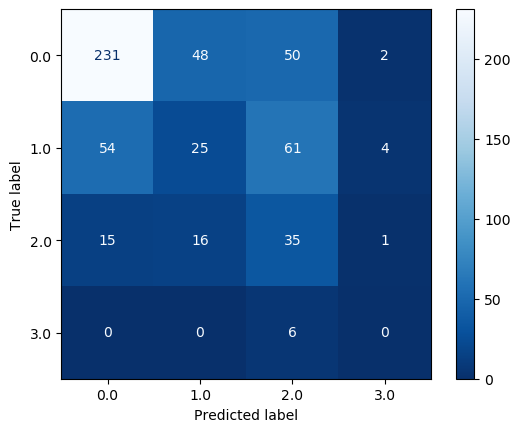

In [11]:
ConfusionMatrixDisplay.from_estimator(
    estimator=tuned_model.best_estimator_,
    X=X_test_subset, y=y_test,
    cmap = 'Blues_r')

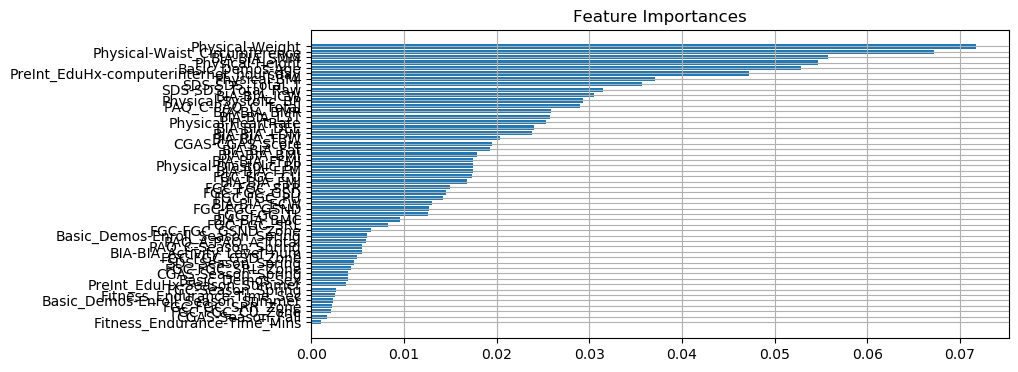

In [12]:
subset_feature_names = X_train_subset.columns.tolist()

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(X_train_subset.shape[1]), sorted(tuned_model.best_estimator_.feature_importances_)[::-1])
ax.set_title("Feature Importances")
ax.set_yticks(range(X_train_subset.shape[1]))
ax.set_yticklabels(np.array(subset_feature_names)[np.argsort(tuned_model.best_estimator_.feature_importances_)[::-1]])
ax.invert_yaxis() 
ax.grid()

As we can see in this way we get a slighty lower accuracy due to less possible features to use but we get a more robust and efficient solution since we have a lower risk of overfitting.